# Analyzing Topographic Trends in Forest Cutblocks across British Columbia  

In [1]:
import seaborn as sns
import geopandas as gpd
import contextily as cx
import pandas as pd
import rasterio
import numpy as np
import matplotlib.pyplot as plt

Load the dataset below. This reads the area of interest (AOI) to keep processing to a limited area for now.

In [2]:
aoi_fpath = r'data/cutblocks_topo/aoi.gpkg'
aoi = gpd.read_file(aoi_fpath)

cutblocks_fpath = r'data/cutblocks_topo/cutblocks.gpkg'
cutblocks = (gpd.read_file(cutblocks_fpath)
             .rename(columns={'HRVST_MD_R': 'harvest_year'}))

# Set DEM fpath
dem_fpath = r'data/cutblocks_topo/dem.tif'

Before diving into analysis, let’s visualize the Area of Interest (AOI) on a basemap. This gives us a clear spatial context for the region we’re working with and helps us interpret results more effectively. To enhance visibility, we create a buffered version of the AOI to set the map extent, and then overlay the original AOI in red on top of satellite imagery.

Text(0.5, 1.0, 'Area of Interest (AOI)')

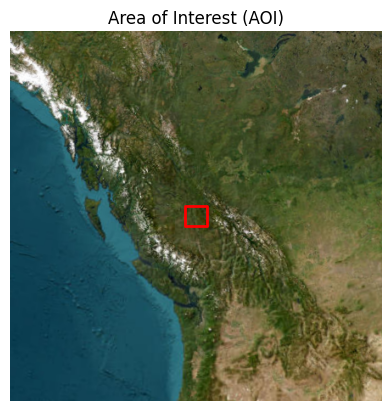

In [3]:
aoi_buf = aoi.copy()
aoi_buf.geometry = aoi_buf.geometry.buffer(1_000_000, cap_style='square')

fig, ax = plt.subplots()
aoi_buf.plot(ax=ax, facecolor='none', edgecolor='none')
aoi.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
ax.set_axis_off()

cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery,
                attribution="", crs=aoi.crs)

plt.title('Area of Interest (AOI)')

In [4]:
# Check size of AOI
aoi_area_km2 = aoi_buf.geometry.area[0] / 1e6

print(format(round(aoi_area_km2), ","), "km Squared")


3,686,567 km Squared


Lets take a look at the number of cutblocks in larger dataset extent. Given that we have a large number, it means we have a good dataset to do any analysis on. 

In [5]:
print(len(cutblocks))

33387


Let’s begin by summarizing how harvest activity has varied over time. By looking at the distribution of `harvest_year`, we can get a sense of which years had more or less harvesting. This kind of high-level overview helps us explore trends and might lead us to ask deeper, more focused questions about the data.

<Axes: xlabel='harvest_year', ylabel='Count'>

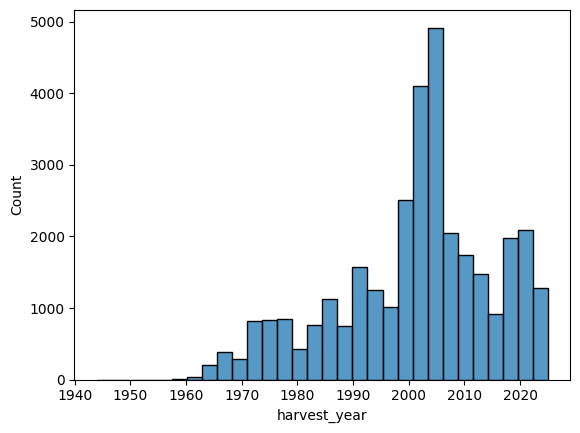

In [6]:
sns.histplot(cutblocks['harvest_year'], bins=30)

Check range of harvest years

In [7]:
cutblocks.agg({'harvest_year': ['min', 'max']})

,harvest_year
min,1944
max,2025


After exploring the distribution of harvest years overall, we now map the cutblocks by their `harvest_year` to visualize where harvesting has occurred over time. This allows us to observe spatial patterns in harvesting activity. For example, whether newer cutblocks are expanding into new areas or whether certain regions were harvested earlier than others.

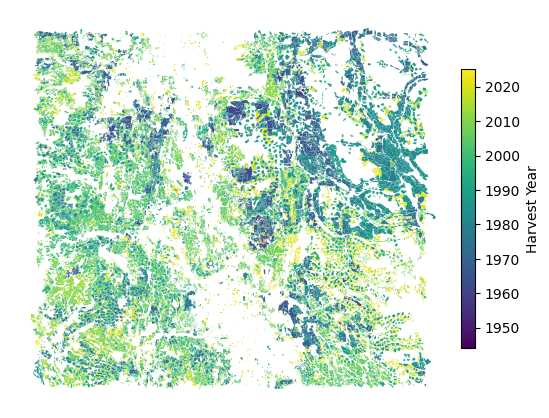

In [8]:
# Visualize cutblocks by year
fig, ax = plt.subplots(figsize=(6, 6))
cutblocks.plot(ax=ax, column='harvest_year')
ax.set_axis_off()
plt.colorbar(ax.collections[0], ax=ax, label='Harvest Year', fraction=0.03, pad=0.01)

This block of code loads a Digital Elevation Model (DEM) raster file, processes it for analysis/visualization, and ensures it’s aligned with your vector data (e.g., cutblocks)

In [9]:
# Load the DEM and visualize
with rasterio.open(dem_fpath) as dem_src:

    # Load the raster values
    dem = dem_src.read(1)

    # Get the raster transform (i.e., affine matrix)
    dem_transform = dem_src.transform

    # Get the resolutiono and coordinate reference system (CRS)
    dem_res = dem_src.res
    dem_crs = dem_src.crs
    print(f"DEM resolution: {dem_res}")
    print(f"DEM CRS: {dem_crs.to_wkt()}")

    # Set nodata values to numpy NA
    nodata_value = dem_src.nodata
    dem = dem.astype('float16')
    dem[dem == nodata_value] = np.nan

    # Ensure the DEM and cutblocks have the same CRS
    assert dem_crs == cutblocks.crs, "CRS of DEM and cutblocks do not match!"



DEM resolution: (30.188313537117885, 30.18831354658653)
DEM CRS: PROJCS["NAD83 / BC Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",45],PARAMETER["longitude_of_center",-126],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",58.5],PARAMETER["false_easting",1000000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3005"]]


To better understand the topography of the AOI we visualize the Digital Elevation Model (DEM).

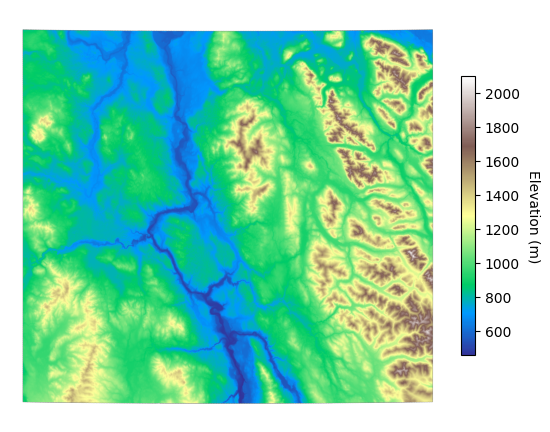

In [10]:
# Set colourmap
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(dem, cmap='terrain')
ax.set_axis_off()

cbar = plt.colorbar(ax.images[0], ax=ax, fraction=0.03, pad=0.01)
cbar.set_label('Elevation (m)', rotation=270, labelpad=15)